In [1]:
import glob, copy, pywt
import scipy
import wfdb
from sklearn import svm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from collections import Counter
from ecgdetectors import Detectors
from read_data import ECGSample, ECGDataset
import random

# Load dataset

In [2]:
dataset = ECGDataset()

# Train val test split 50% 25% 25%

In [3]:
train= [ 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
test_val = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

random.shuffle(test_val)
test, val = test_val[:len(test_val)//2], test_val[len(test_val)//2:]

In [340]:
train_x, train_y, test_x, test_y, val_x, val_y = dataset.get_train_test_sets(train, test, val)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(val_x.shape)
print(val_y.shape)

### cahnge labels to binary 0 normal beat 1 beat with abnoramality 

train_y[train_y==1] = 0
train_y[train_y!=0] = 1

test_y[test_y==1] = 0
test_y[test_y!=0] = 1

val_y[val_y==1] = 0
val_y[val_y!=0] = 1

(51000, 70)
(51000,)
(26584, 70)
(26584,)
(23107, 70)
(23107,)


In [341]:
print(sum(train_y == 1))
print(sum(train_y == 2))
print(sum(train_y == 3))
print(sum(train_y == 4))
print(sum(train_y == 0))

5186
0
0
0
45814


In [342]:
sum(val_y==0)

20477

# Downsample majority class

In [186]:
from sklearn.utils import resample
import pandas as pd

df_train = pd.DataFrame(train_x)
df_train['y'] = train_y

df_majority = df_train[df_train.y==0]
df_minority = df_train[df_train.y!=0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=sum(train_y == 0),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.y.value_counts()

0    45814
1     5186
Name: y, dtype: int64

In [343]:
from sklearn import preprocessing
#c= np.array(df_downsampled.drop(['y'], axis = 1))
X_train_cnn = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1), "A")
Y_train_cnn = np.array(train_y)
#preprocessing.label_binarize(np.array(train_y), [1, 2, 3, 4, 5])


X_val_cnn = np.reshape(val_x, (val_x.shape[0], val_x.shape[1], 1), "A")
X_test_cnn = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1), "A")


Y_val_cnn = val_y
#preprocessing.label_binarize(val_y, [1, 2, 3, 4, 5])
Y_test_cnn = test_y
#preprocessing.label_binarize(test_y, [1, 2, 3, 4, 5])

In [295]:
# from sklearn import svm

# class_weights = {}
# for c in range(2):
#     class_weights.update({c:len(Y_train_cnn) / float(np.count_nonzero(Y_train_cnn == c))})
    
# clf = svm.SVC(kernel='rbf', degree=3, gamma='auto', 
#                     coef0=0.0, shrinking=True,  tol=0.001, 
#                     cache_size=200, class_weight=class_weights, verbose=False, 
#                     max_iter=-1, random_state=None)
# clf.fit(X_train_cnn, Y_train_cnn)

SVC(C=1.0, break_ties=False, cache_size=200,
    class_weight={0: 1.1131968393940717, 1: 9.834168916313152}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [296]:
# clf.score(np.concatenate((X_val_cnn, X_test_cnn), axis=0), np.concatenate((Y_val_cnn, Y_test_cnn), axis=0)) 

0.7446620112293977

# Build 1D CNN for binary classification


In [344]:
from keras.layers import Conv1D, Dense, Flatten, Dropout,MaxPooling1D
from keras.models import Sequential
from keras.utils import to_categorical
import keras

In [387]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 7, activation = "relu", input_shape = (70, 1)))
model.add(MaxPooling1D(2))
model.add(Dropout(rate= 0.5))
model.add(Conv1D(filters = 64, kernel_size = 5, activation = "relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(rate= 0.50))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ["accuracy", keras.metrics.AUC()])

In [388]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 64, 128)           1024      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 32, 128)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 28, 64)            41024     
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 14, 64)            0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 896)             

In [389]:
history = model.fit(X_train_cnn, Y_train_cnn, batch_size = 64, epochs=5, validation_data = (X_val_cnn, Y_val_cnn))

Train on 51000 samples, validate on 23107 samples
Epoch 1/5
51000/51000 [==============================] - 40s 788us/step - loss: 0.1593 - accuracy: 0.9506 - auc_17: 0.9194 - val_loss: 0.3884 - val_accuracy: 0.8466 - val_auc_17: 0.7858
Epoch 2/5
51000/51000 [==============================] - 38s 737us/step - loss: 0.0795 - accuracy: 0.9767 - auc_17: 0.9758 - val_loss: 0.5658 - val_accuracy: 0.7966 - val_auc_17: 0.6746
Epoch 3/5
51000/51000 [==============================] - 39s 768us/step - loss: 0.0609 - accuracy: 0.9819 - auc_17: 0.9859 - val_loss: 0.4985 - val_accuracy: 0.7987 - val_auc_17: 0.7598
Epoch 4/5
51000/51000 [==============================] - 40s 790us/step - loss: 0.0521 - accuracy: 0.9847 - auc_17: 0.9879 - val_loss: 0.7973 - val_accuracy: 0.7507 - val_auc_17: 0.6956
Epoch 5/5
51000/51000 [==============================] - 35s 679us/step - loss: 0.0477 - accuracy: 0.9853 - auc_17: 0.9910 - val_loss: 0.6846 - val_accuracy: 0.7560 - val_auc_17: 0.7834


In [390]:
print(history.history)

{'val_loss': [0.3884255517908216, 0.5657629082824586, 0.4985454670192775, 0.7972731325178793, 0.6846100333209909], 'val_accuracy': [0.8465833067893982, 0.7966417074203491, 0.7987189888954163, 0.7507249116897583, 0.7560479640960693], 'val_auc_17': [0.7857695817947388, 0.6746392846107483, 0.7597654461860657, 0.6955785155296326, 0.783390462398529], 'loss': [0.15930805082765281, 0.07949398707554621, 0.06090164310675041, 0.05208013172827515, 0.04766402109274093], 'accuracy': [0.9505686, 0.9766667, 0.9818627, 0.98470587, 0.9853137], 'auc_17': [0.9194433, 0.97578293, 0.985912, 0.98787004, 0.9909648]}


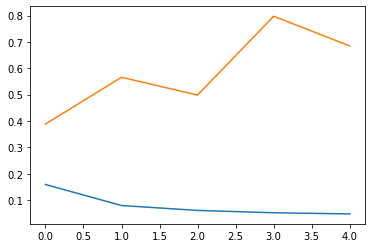

In [391]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [392]:
y_pred_probab = model.predict(X_test_cnn)

In [393]:
y_pred_probab.shape

(26584, 1)

In [394]:
Y_test_cnn.shape

(26584,)

In [395]:
y_pred_probab[y_pred_probab>0.9]=1
y_pred_probab[y_pred_probab<=0.9]=0

In [396]:
len(y_pred_probab)

26584

In [404]:
from  sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

cm = confusion_matrix(Y_test_cnn, y_pred_probab)

In [405]:
cm

array([[22981,   568],
       [  958,  2077]], dtype=int64)

In [406]:
accuracy_score(Y_test_cnn, y_pred_probab)

0.9425970508576588

In [407]:
roc_auc_score(Y_test_cnn, y_pred_probab)

0.8301146692413162

# Build 2-nd CNN to classify abnormal signals

In [204]:
train_x, train_y, test_x, test_y, val_x, val_y = dataset.get_train_test_sets(train, test, val)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(val_x.shape)
print(val_y.shape)

(51000, 70)
(51000,)
(26584, 70)
(26584,)
(23107, 70)
(23107,)


In [208]:
from sklearn.utils import resample
import pandas as pd

df_train = pd.DataFrame(train_x)
df_train['y'] = train_y

df_train = df_train.drop(df_train[df_train.y == 1].index)

df_test = pd.DataFrame(test_x)
df_test['y'] = test_y

df_test = df_test.drop(df_test[df_test.y == 1].index)

df_val = pd.DataFrame(val_x)
df_val['y'] = val_y

df_val = df_val.drop(df_val[df_val.y == 1].index)

In [226]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,y
359,-1.0825,-1.0425,-1.0625,-1.1000,-1.0700,-1.0900,-1.0925,-1.0800,-1.0550,-1.0800,...,-0.6200,-0.5200,-0.4200,-0.2975,-0.2550,-0.2375,-0.3075,-0.3600,-0.4950,5
419,-0.8475,-0.8550,-0.8650,-0.8500,-0.8150,-0.8150,-0.7650,-0.7200,-0.6650,-0.5875,...,-0.2100,-0.1925,-0.2075,-0.3000,-0.4200,-0.4700,-0.5300,-0.5900,-0.5850,2
643,-0.8300,-0.8050,-0.8200,-0.8375,-0.8125,-0.8300,-0.8300,-0.8300,-0.8325,-0.8550,...,-0.3225,-0.2525,-0.2200,-0.2050,-0.2550,-0.3800,-0.4700,-0.5600,-0.6350,2
898,-1.1300,-1.0700,-1.0775,-1.0775,-1.1375,-1.1150,-1.1825,-1.1375,-1.1375,-1.1450,...,-0.2475,-0.1925,-0.2600,-0.2750,-0.3400,-0.4375,-0.5725,-0.5800,-0.6075,5
1536,-0.1325,-0.0550,-0.0125,0.0200,-0.0300,-0.1400,-0.2325,-0.3575,-0.4550,-0.4900,...,-0.0225,-0.0250,-0.0600,-0.1950,-0.3075,-0.4025,-0.4925,-0.5150,-0.5375,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48730,-1.3500,-1.3350,-1.3875,-1.4125,-1.4300,-1.4800,-1.5100,-1.5000,-1.5300,-1.5650,...,-0.1075,-0.1600,-0.2275,-0.3100,-0.4825,-0.6075,-0.6675,-0.7800,-0.8275,3
48731,-0.1075,-0.1375,-0.2150,-0.2825,-0.4325,-0.5925,-0.6450,-0.7575,-0.8175,-0.8325,...,-0.4225,-0.5950,-0.6875,-0.8075,-0.8675,-0.8750,-0.8825,-0.9300,-0.8650,3
48733,-1.4250,-1.4925,-1.5025,-1.5175,-1.6000,-1.6250,-1.6400,-1.6800,-1.6550,-1.6150,...,-0.0225,-0.0400,-0.1025,-0.2750,-0.3975,-0.5325,-0.6875,-0.7375,-0.7875,3
48734,-0.8850,-0.8725,-0.8700,-0.8925,-0.8675,-0.8925,-0.9250,-0.8975,-0.9175,-0.9425,...,-0.1400,-0.1925,-0.3300,-0.4450,-0.5900,-0.7175,-0.7625,-0.8425,-0.8750,3


In [321]:
c= np.array(df_train.drop(['y'], axis = 1))
X_train_cnn = np.reshape(c, (c.shape[0], c.shape[1], 1), "A")
Y_train_cnn = preprocessing.label_binarize(np.array(df_train.y), [2, 3, 4, 5])

c= np.array(df_test.drop(['y'], axis = 1))
X_test_cnn = np.reshape(c, (c.shape[0], c.shape[1], 1), "A")
Y_test_cnn = preprocessing.label_binarize(np.array(df_test.y), [2, 3, 4, 5])

c= np.array(df_val.drop(['y'], axis = 1))
X_val_cnn = np.reshape(c, (c.shape[0], c.shape[1], 1), "A")
Y_val_cnn = preprocessing.label_binarize(np.array(df_val.y), [2, 3, 4, 5])

In [322]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 7, activation = "relu", input_shape = (70, 1)))
model.add(MaxPooling1D(2))
model.add(Dropout(rate= 0.30))
model.add(Conv1D(filters = 64, kernel_size = 5, activation = "relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(rate= 0.30))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(4, activation = 'sigmoid'))

model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy", keras.metrics.AUC()])

In [329]:
history = model.fit(X_train_cnn, Y_train_cnn, batch_size = 32, epochs=5, validation_data = (X_val_cnn, Y_val_cnn))

Train on 5186 samples, validate on 2630 samples
Epoch 1/5
5186/5186 [==============================] - 5s 923us/step - loss: 0.0598 - accuracy: 0.9811 - auc_15: 0.9951 - val_loss: 0.0893 - val_accuracy: 0.9787 - val_auc_15: 0.9926
Epoch 2/5
5186/5186 [==============================] - 4s 864us/step - loss: 0.0516 - accuracy: 0.9817 - auc_15: 0.9960 - val_loss: 0.1238 - val_accuracy: 0.9817 - val_auc_15: 0.9899
Epoch 3/5
5186/5186 [==============================] - 5s 873us/step - loss: 0.0552 - accuracy: 0.9826 - auc_15: 0.9931 - val_loss: 0.1242 - val_accuracy: 0.9738 - val_auc_15: 0.9882
Epoch 4/5
5186/5186 [==============================] - 5s 1ms/step - loss: 0.0543 - accuracy: 0.9807 - auc_15: 0.9954 - val_loss: 0.1471 - val_accuracy: 0.9760 - val_auc_15: 0.9882
Epoch 5/5
5186/5186 [==============================] - 5s 1ms/step - loss: 0.0469 - accuracy: 0.9853 - auc_15: 0.9947 - val_loss: 0.1091 - val_accuracy: 0.9776 - val_auc_15: 0.9909


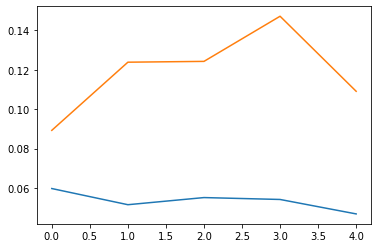

In [330]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [335]:
y_pred_probab = model.predict(X_val_cnn)
y_pred = np.argmax(y_pred_probab, axis = 1)+2

In [336]:
cm = confusion_matrix(np.array(df_val.y), y_pred)

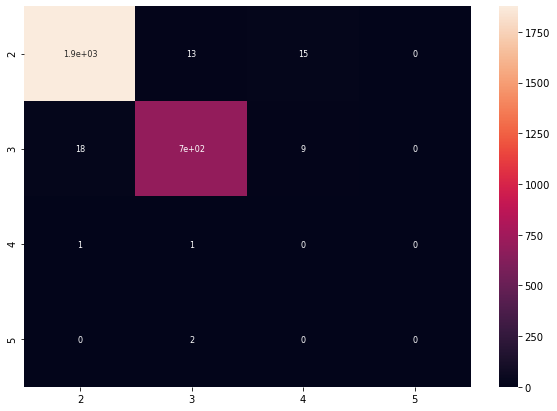

In [337]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index = [i for i in "2345"],
                  columns = [i for i in "2345"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

In [338]:
accuracy_score(np.array(df_val.y), y_pred)

0.9775665399239544

In [339]:
cm

array([[1876,   13,   15,    0],
       [  18,  695,    9,    0],
       [   1,    1,    0,    0],
       [   0,    2,    0,    0]], dtype=int64)